In [215]:
import re
import numpy as np
import pandas as pd
import requests,time
import datetime
from scipy import stats
import csv
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import json
import webbrowser
import warnings
import PyPDF2
import io
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


The following 3 cells are used for scarpping the data from the Loksabha site. as the spreadsheets they were giving were not matching with the records shown on the website.

In [34]:

# ! will open these following urls on the browser

websites = ['https://sansad.in/api_ls/question/qetFilteredQuestionsAns?loksabhaNo=16&sessionNumber=2&pageNo=1&locale=en&pageSize=5877','https://sansad.in/ls/questions/questions-and-answers','https://loksabha.nic.in/writereaddata/our%20parliament/Question%20Hour%20in%20Lok%20sabha.pdf','https://shivsamshankars.medium.com/how-to-get-a-question-selected-in-the-indian-parliament-rigged-system-or-just-a-flawed-one-8e9de683e126']
for i in range(len(websites)):
    webbrowser.open(websites[i])

In [2]:

# ! no need to run this cell
s = HTMLSession()

def get_recordsize(lok_sabha,session_no,page_no):
    """_Get the data for LS, fetch data from the url_

    Args:
        

    Returns:
        _list_: _json_or_dictionary_
    """    ''''''
    lok_sabha = lok_sabha
    session_no = session_no
    page_no = page_no

    url = f'https://sansad.in/api_ls/question/qetFilteredQuestionsAns?loksabhaNo={lok_sabha}&sessionNumber={session_no}&pageNo=1&locale=en&pageSize='
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    list = soup.text.strip().replace('null',""'null'"")
    list1 = json.loads(list)
    record_size =list1[0]['totalRecordSize']

    url   = f'https://sansad.in/api_ls/question/qetFilteredQuestionsAns?loksabhaNo={lok_sabha}&sessionNumber={session_no}&pageNo=1&locale=en&pageSize={record_size}' 
    page  = requests.get(url)
    soup2 = BeautifulSoup(page.text, 'html')
    list2f  = soup2.text.strip().replace('null',""'null'"")
    list2f = json.loads(list2f)
    return list2f


In [3]:

# ! Do not run this cell

def get_df(lok_sabha,session_no,page_no):
    """_return a list of data_frames_

    Args:
        lok_sabha (_int_): _takes_the_lok_Sabha_ no._
        session_no (_int_): _Sessionnumber_LS16_has_no_1stsession_
        page_no (_int_): _keep_it_one_

    Returns:
        _list_: _containing dataframes_
    """    """"""
    df = pd.DataFrame.from_dict(get_recordsize(lok_sabha,session_no,page_no)[0]['listOfQuestions'])
    return df
ls16_session_wise = [get_df(16,sess,1) for sess in range(2,18)]
ls17_session_wise = [get_df(17,sess,1) for sess in range(1,13)]
# * runtime_was = 14m 58.5s
#--------------------------------------------------------------------------------------------------------------------------------


In [5]:
# ! do not run this cell
# ? This is the cell that takes 

num = 1  # data has been created already
for df in ls16_session_wise:
    num += 1
    df.to_json(f'16session{num}.json', orient = 'records', compression = 'infer')

num_ = 0
for df in ls17_session_wise:
    num_ += 1
    df.to_json(f'17session{num_}.json', orient = 'records', compression = 'infer')

#### From here
    The data has been already downloaded in json format
    You choose the data range in the below cell, you want to do the analysis for

In [118]:
ls16_sess = [(pd.read_json(f'16session{i}.json', convert_dates=False)) for i in range(2,18)]
ls17_sess = [(pd.read_json(f'17session{i}.json', convert_dates=False)) for i in range(1,13)]

ls_sess = [*ls16_sess ,*ls17_sess]

# * appending all the sessions to the one dataframe
concatdf = pd.concat(ls_sess, ignore_index=True) # ? only 6 sessions rn

# ? cleaning the data for member names and dates 
# *  Date formatting 
concatdf['date'] = concatdf['date'].str.replace('.','')
concatdf['date'] = (concatdf['date'].str[-4:]+ concatdf['date'].str[2:4] + concatdf['date'].str[:2]).apply(int)  # ? date formating
# *  Member name formatting
concatdf['memberstring'] = [','.join(map(str, l)) for l in concatdf['member']] # ? cleaning the data for member
fourth_column = concatdf.pop('memberstring')
concatdf.insert(4,'memberstring',fourth_column)
concatdf["memberstring"].str.strip()

concatdf["type"].str.strip()
# * _________________________________________________________________________
# ? Choose a range of dates 
start_date = 20140707
end_date =  20160303


# concatdf.sort_values(by = 'date')


# * total dates, subjects unique ________________________________________________________________
subjects_unique = concatdf['subjects']
subjects_unique.unique()
print(len(subjects_unique.unique()))
print(len(subjects_unique))
session_dates = concatdf['date']
len(session_dates.unique())

#concatdf
concatdf['questionText'] = concatdf.questionText.str.replace("\n\r\n","")
# ! concatdf = concatdf.query(f'date >= {start_date}  & date <= {end_date}') # 20140707 to 20230811

concatdf = concatdf.sort_values(by = 'date', ignore_index= True)


108948
134866


In [72]:
idx_first_empty_row = concatdf.iloc[:, 9].isna()
blank_row_index =  [i for i, x in enumerate(idx_first_empty_row) if x][0]
blank_row_index
idx_first_empty_row #= concatdf.iloc[19095:20000,:]


concatdf.questionText.str.replace("\n\r\n","")
concatdf['questionText'] = concatdf.questionText.str.replace("\n\r\n","")



#concatdf[19096:19105]
blank_row_index

19098

In [171]:
 # 23506

sample_df = concatdf[19097:19108]
def pdf_indexes(dataframe):
    
    alltr_indexes = []
    allfa_indexes = []

    for i in range(19097,dataframe.index[-1]):
        val = dataframe.questionsFilePath[i]
        if 'pdf' in val:
            alltr_indexes.append(i)
        else:
            allfa_indexes.append(i)

    return alltr_indexes, allfa_indexes

indlist = pdf_indexes(sample_df)[0]
sample_df


,quesNo,subjects,lokNo,member,memberstring,ministry,type,date,questionText,answerText,questionsFilePath,questionsFilePathHindi,sessionNo,supplementaryQuestionResDtoList,supplementaryType
19097,6973,RECRUITMENT OF DEFENCE PERSONNEL,16,"[SHANTA KUMAR, R. GOPALAKRISHNAN, DALPAT SINGH...","SHANTA KUMAR,R. GOPALAKRISHNAN,DALPAT SINGH PA...",DEFENCE,UNSTARRED,20150508,(a) the total number of recruitment camps/\r\n...,\r\n\n\nMINISTER OF DEFENCE (SHRI MANOHAR PARR...,,NaN,4,NaN,False
19098,171,Pollution of Ganga and Yamuna Rivers,16,"[VINAYAK BHAURAO RAUT, SHRIKANT EKNATH SHINDE,...","VINAYAK BHAURAO RAUT,SHRIKANT EKNATH SHINDE,RA...","ENVIRONMENT, FORESTS AND CLIMATE CHANGE",UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19099,170,Suicide by Farmers,16,"[RAMA KISHORE SINGH, RAGHAV LAKHANPAL, SHARAD ...","RAMA KISHORE SINGH,RAGHAV LAKHANPAL,SHARAD TRI...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19100,169,Use of Pesticides,16,"[ARKA KESHARI DEO, P.K.SREEMATHI TEACHER, NAGA...","ARKA KESHARI DEO,P.K.SREEMATHI TEACHER,NAGARAJ...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19101,168,Onion Production,16,"[MEENAKASHI LEKHI, M. UDHAYAKUMAR, T. RADHAKRI...","MEENAKASHI LEKHI,M. UDHAYAKUMAR,T. RADHAKRISHN...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19102,167,Sowing areas under Pulses and Oilseeds,16,"[DHANANJAY BHIMRAO MAHADIK, M. UDHAYAKUMAR, T....","DHANANJAY BHIMRAO MAHADIK,M. UDHAYAKUMAR,T. RA...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19103,164,Establishing Heavy Industries in the Country,16,[NISHIKANT DUBEY],NISHIKANT DUBEY,HEAVY INDUSTRIES AND PUBLIC ENTERPRISES,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19104,165,Price Rise,16,"[R.K. BHARATHI MOHAN, BOORA NARSAIAH GOUD, BHE...","R.K. BHARATHI MOHAN,BOORA NARSAIAH GOUD,BHEEMR...","CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION",UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19105,163,Impact of Monsoon on Agriculture,16,"[C. N. JAYADEVAN, BOORA NARSAIAH GOUD, CHANDRA...","C. N. JAYADEVAN,BOORA NARSAIAH GOUD,CHANDRA PR...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19106,162,Decline in Procurement of Foodgrains,16,"[SIRAJUDDIN AJMAL, RAVNEET SINGH]","SIRAJUDDIN AJMAL,RAVNEET SINGH","CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION",UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False


word cloud for the all the starred and unstarred qurstions

1. Do for only starred
2. For only unstarred 


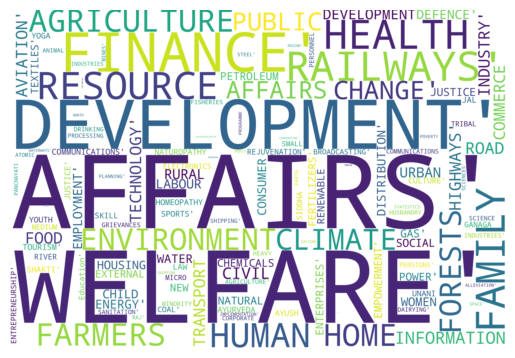

In [224]:
#Total number of rows are 134866 and 

def subjects_uniqueliststr(dataframe):
    subjects_unique = dataframe['ministry']
    subjects_unique_list =  list(subjects_unique)
    subjects_unique_liststr = str(subjects_unique_list)
    subjects_unique_liststr
    return subjects_unique_liststr

text1 = subjects_uniqueliststr(concatdf)

word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                        width = 3048, height = 2080).generate(text1)
#word_cloud1.to_file('sampledf.png')


# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()


Questions, being scraped from the individual pdfs and being pasted to the dataframe in the questionText column  index starts from 19098

In [ ]:

# ! Question appending function
# ! this works for the pdf



def scrape_pdf_and_questions(dataframe):

   #if "pdf" in url:
  indices = pdf_indexes(dataframe)[0]
  for ind in indices:                               # ? could just making a list of strings and pasting them sideways be faster
    url = dataframe.questionsFilePath[ind]
    if "https://" in url:
      r = requests.get(url)
      f = io.BytesIO(r.content)
      reader = PyPDF2.PdfReader(f)
      contents = reader.pages[0].extract_text().split('\n')
      string_contents = str(contents)
      dataframe.loc[ind,'questionText'] = string_contents
      #have to do something with regualar_expressions
    
      #listn = [','.join(map(str, l)) for l in contents]
    
scrape_pdf_and_questions(sample_df)


In [226]:
scrape_pdf_and_questions(sample_df)
sample_df


,quesNo,subjects,lokNo,member,memberstring,ministry,type,date,questionText,answerText,questionsFilePath,questionsFilePathHindi,sessionNo,supplementaryQuestionResDtoList,supplementaryType
19097,6973,RECRUITMENT OF DEFENCE PERSONNEL,16,"[SHANTA KUMAR, R. GOPALAKRISHNAN, DALPAT SINGH...","SHANTA KUMAR,R. GOPALAKRISHNAN,DALPAT SINGH PA...",DEFENCE,UNSTARRED,20150508,(a) the total number of recruitment camps/\r\n...,\r\n\n\nMINISTER OF DEFENCE (SHRI MANOHAR PARR...,,NaN,4,NaN,False
19098,171,Pollution of Ganga and Yamuna Rivers,16,"[VINAYAK BHAURAO RAUT, SHRIKANT EKNATH SHINDE,...","VINAYAK BHAURAO RAUT,SHRIKANT EKNATH SHINDE,RA...","ENVIRONMENT, FORESTS AND CLIMATE CHANGE",UNSTARRED,20150721,"['GOVERNMENT OF INDIA ', 'MINISTRY OF ENVIRON...",NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19099,170,Suicide by Farmers,16,"[RAMA KISHORE SINGH, RAGHAV LAKHANPAL, SHARAD ...","RAMA KISHORE SINGH,RAGHAV LAKHANPAL,SHARAD TRI...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19100,169,Use of Pesticides,16,"[ARKA KESHARI DEO, P.K.SREEMATHI TEACHER, NAGA...","ARKA KESHARI DEO,P.K.SREEMATHI TEACHER,NAGARAJ...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19101,168,Onion Production,16,"[MEENAKASHI LEKHI, M. UDHAYAKUMAR, T. RADHAKRI...","MEENAKASHI LEKHI,M. UDHAYAKUMAR,T. RADHAKRISHN...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19102,167,Sowing areas under Pulses and Oilseeds,16,"[DHANANJAY BHIMRAO MAHADIK, M. UDHAYAKUMAR, T....","DHANANJAY BHIMRAO MAHADIK,M. UDHAYAKUMAR,T. RA...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19103,164,Establishing Heavy Industries in the Country,16,[NISHIKANT DUBEY],NISHIKANT DUBEY,HEAVY INDUSTRIES AND PUBLIC ENTERPRISES,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19104,165,Price Rise,16,"[R.K. BHARATHI MOHAN, BOORA NARSAIAH GOUD, BHE...","R.K. BHARATHI MOHAN,BOORA NARSAIAH GOUD,BHEEMR...","CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION",UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19105,163,Impact of Monsoon on Agriculture,16,"[C. N. JAYADEVAN, BOORA NARSAIAH GOUD, CHANDRA...","C. N. JAYADEVAN,BOORA NARSAIAH GOUD,CHANDRA PR...",AGRICULTURE,UNSTARRED,20150721,NaN,NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False
19106,162,Decline in Procurement of Foodgrains,16,"[SIRAJUDDIN AJMAL, RAVNEET SINGH]","SIRAJUDDIN AJMAL,RAVNEET SINGH","CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION",UNSTARRED,20150721,"[' ', 'GOVERNMENT OF INDIA ', 'MINISTRY OF CO...",NaN,https://sansad.in/getFile/loksabhaquestions/an...,https://sansad.in/getFile/loksabhaquestions/qh...,5,NaN,False


In [221]:
sample_df.questionsFilePath[19099]


'https://sansad.in/getFile/loksabhaquestions/annex/5/AU170.doc?source=pqals'

In [ ]:
concatdf

In [3]:

def combined_questions_members(sub1):
    """_returns a copy of a df only containing the questions which are a club of more than one people_

    Args:
        sub1 (_pandas.Dataframe_): _lok sabha data frame_

    Returns:
        _pandas_: _pandas Dataframe_
    """    ''''''    
    distnames = sub1['member']
    distnames = pd.DataFrame(distnames)

    list_more_1 = [pd.DataFrame(distnames.loc[ind]) for ind in distnames.index if len(distnames['member'][ind]) > 1]
    list_more_1 = [list_more_1[ind].transpose() for ind in range(len(list_more_1))]
    more_than_1 = pd.concat(list_more_1, ignore_index = False) if len(list_more_1) > 0 else pd.DataFrame(columns= concatdf.columns.values)
    full_col_more1 = [ind for ind in more_than_1.index]
    full_col_more_than_1mem = concatdf.loc[full_col_more1,:]
    return full_col_more_than_1mem

#combined_questions_members(concatdf).head()
lok_sabha_members = [concatdf.loc[i,'member'][0] for i in concatdf.index]


for i in combined_questions_members(concatdf).index:
    for j in range(len(concatdf.loc[i,'member'])):
        lok_sabha_members.append(concatdf.loc[i,'member'][j])
    

# ! the number of people that have questioned

lok_sabha_members = list(set(lok_sabha_members))
#lok_sabha_members

In [4]:

# ? this is an example of how we will save the DataFrames in a folder named Sheets in excel format
name = concatdf.loc[concatdf['memberstring'].str.contains("TAPAS PAUL",case = False)]
name.type.value_counts()

type
UNSTARRED     5
Name: count, dtype: int64

In [8]:
# date = '20140814'

# sub1 = concatdf.query(f'type == "STARRED   " and date == "{date}"') # ! three spaces after STARRED
# sub3 = concatdf.loc[concatdf['memberstring'].str.contains("BALABHADRA MAJHI",case = False)]
# sub4 = sub3.query('type == "STARRED   "')

# sb3 = sub2.query(f'type == "STARRED   "')


# sb3.index
warnings.filterwarnings("ignore", 'This pattern is interpreted as a regular expression, and has match groups.To actually get the groups, use str.extract.')


def get_star_unstar_tot_club(member_name,data_frame):
    member_name = member_name
    #warnings.filterwarnings("ignore", 'This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.')
    the_name = data_frame.loc[data_frame['memberstring'].str.contains(member_name,case = False)]
    clubbed_list = []

    for i in combined_questions_members(the_name).index:
        for j in range(len(the_name.loc[i,'member'])):
            clubbed_list.append(the_name.loc[i,'member'][j])
    club_count = clubbed_list.count(f'{member_name}')


    unstarred = 0 if len(the_name.type.value_counts()) < 1 else the_name.type.value_counts().iloc[0]
    starred   = 0 if len(the_name.type.value_counts()) < 2 else the_name.type.value_counts().iloc[1] 
    dictionary_name_ques = {'MemberName' :f'{member_name}',
                            'Total_Questions' : unstarred+starred,
                            'Clubbed': club_count,
                            'Unstarred': unstarred,
                            'Starred' : starred,
                            '% Starred' : 1+starred/(1+unstarred+starred) -1

    }
    return dictionary_name_ques
get_star_unstar_tot_club('JYOTIRADITYA MADHAVRAO SCINDIA')



# ****************************************************************








df club_star_unstar(member,)
    data = []
    for member_name in lok_sabha_members:
        data.append(get_star_unstar_tot_club(member_name,concatdf))
    comparison_df = pd.DataFrame.from_dict(data)



In [9]:
comparison_df.sort_values('Starred', ascending= False)[:40]

,MemberName,Total_Questions,Clubbed,Unstarred,Starred,% Starred
35,DHARMENDRA YADAV,428,414,386,42,0.097902
339,SUPRIYA SADANAND SULE,483,454,444,39,0.080579
61,NISHIKANT DUBEY,339,217,303,36,0.105882
296,RAJEEV SHANKARRAO SATAV,434,424,401,33,0.075862
329,DHANANJAY BHIMRAO MAHADIK,465,462,433,32,0.068670
299,ASADUDDIN OWAISI,400,230,369,31,0.077307
375,VINOD KUMAR BOIANAPALLI,266,176,235,31,0.116105
238,BHARTRUHARI MAHTAB,236,211,206,30,0.126582
36,JYOTIRADITYA MADHAVRAO SCINDIA,364,297,334,30,0.082192
342,SHIVAJI ADHALRAO PATIL,476,448,448,28,0.058700


In [7]:
the_name = concatdf.loc[concatdf['memberstring'].str.contains("BRIJBHUSHAN SHARAN SINGH",case = False)]
lok_sabha_membersvn = []
for i in combined_questions_members(the_name).index:
    for j in range(len(the_name.loc[i,'member'])):
        lok_sabha_membersvn.append(the_name.loc[i,'member'][j])
    

lok_sabha_membersvn.count('SUPRIYA SADANAND SULE')
the_name


,quesNo,subjects,lokNo,member,memberstring,ministry,type,date,questionText,answerText,questionsFilePath,questionsFilePathHindi,sessionNo,supplementaryQuestionResDtoList,supplementaryType


In [17]:
v = pd.read_json("16session2.json")
v[1000:].to_dict("records")

[{'quesNo': 4437,
  'subjects': 'SHARE OF STATES IN CSS ',
  'lokNo': 16,
  'member': ['KRISTAPPA NIMMALA'],
  'ministry': 'FINANCE',
  'type': 'UNSTARRED ',
  'date': Timestamp('2014-08-08 00:00:00'),
  'questionText': '\n\r\n(a)  whether the Government has urged the State Governments to maintain their share in the \r\nCentrally Sponsored Scheme (CSS) so as to ensure that the budget outlay of the schemes stay \r\nwithin the outlay approved by the Planning Commission;\r\n\r\n(b)  if so. the details thereof and the action taken thereon State-wise;\r\n\r\n(c)  the details of the step taken by the Government to ensure better coordination amongst \r\nvarious Ministries for optimum utilization of resources and avoidance of overlapping of work;\r\n\r\n(d)  whether instructions have been issued for strict compliance of the guidelines with regard \r\nto the ongoing CSS during the 12th Five Year Plan and identification of schemes which can be \r\nmerged/ subsumed so as to avoid needless expendi